# Part-1: Dimensionality reduction using Auto-Encoder

In [141]:
import numpy as np
import pandas as pd
from copy import deepcopy
from numpy import linalg as LA
from sklearn.metrics.cluster import contingency_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [2]:
dataSet=pd.read_csv("data.csv")

In [3]:
label=dataSet['xAttack']
dataSet=dataSet.drop(['xAttack'],axis=1)
dataSet=np.array((dataSet-np.mean(dataSet))/np.std(dataSet))
print("Dimensions before AutoEncoder: ",dataSet.shape)

Dimensions before AutoEncoder:  (24998, 29)


In [25]:
class Layer:
    def __init__(self,currentSize):
        self.layerSize=currentSize
        self.Weights=None
        self.Bias=None
        self.Z=None
        self.Activations=None
        self.ActFunction=None
        self.dActFunction=None

class NeuralNetwork:
    
    def __init__(self,nLayers,layerSizes,hLayerActFunction,epochs,learningRate):
        
        self.nLayers=nLayers
        self.layers=[]
        self.epochs=epochs
        self.learningRate=learningRate
        
        for x in range(self.nLayers):
            self.layers.append(Layer(layerSizes[x]))
        
        for x in range(self.nLayers):
            self.layers[x].Weights=np.random.randn(layerSizes[x],layerSizes[x-1])*np.sqrt(2/layerSizes[x-1])
            self.layers[x].Bias=np.zeros((layerSizes[x],1))
            self.layers[x].ActFunction=getattr(self,hLayerActFunction)
            self.layers[x].dActFunction=getattr(self,"der"+hLayerActFunction)
        
    def forwardProp(self,X): # making the prediction on current weights
        self.layers[0].Activations=self.layers[0].ActFunction(X.T)
        for i in range(1,self.nLayers):
            self.layers[i].Z=np.dot(self.layers[i].Weights,self.layers[i-1].Activations)+self.layers[i].Bias
            self.layers[i].Activations=self.layers[i].ActFunction(self.layers[i].Z)
        
    def cost(self,X):
        Y=self.layers[-1].Activations.T
        return np.sum(np.sum(np.power((X-Y),2))/len(X))
    
    def backProp(self,X,Y): # back propogating the error
        
        self.layers[-1].dZ=(self.layers[-1].Activations-Y.T)*self.layers[-1].dActFunction(self.layers[-1].Activations)
        self.layers[-1].dW=np.dot(self.layers[-1].dZ,self.layers[-2].Activations.T)/len(Y)
        self.layers[-1].dB=(np.sum(np.array(self.layers[-1].dZ),axis=1,keepdims=True))/len(Y)
        
        for i in range(self.nLayers-2,0,-1):
            self.layers[i].dZ=np.dot(self.layers[i+1].Weights.T,self.layers[i+1].dZ)*(self.layers[i].dActFunction(self.layers[i].Z))
            self.layers[i].dW=np.dot(self.layers[i].dZ,self.layers[i-1].Activations.T)/len(Y)
            self.layers[i].dB=(np.sum(np.array(self.layers[i].dZ),axis=1,keepdims=True))/len(Y)
    
        for i in range(1,self.nLayers):
            self.layers[i].Weights-=self.learningRate*(self.layers[i].dW)
            self.layers[i].Bias-=self.learningRate*(self.layers[i].dB)
    
    def derSIGMOID(self,z):
        s=self.SIGMOID(z)
        return s*(1-s)
    
    def LINEAR(self,z):
        return z
    
    def derLINEAR(self,z):
        return 1
    
    def TANH(self,x):
        e_2x=np.exp(2*x)
        return (e_2x-1)/(e_2x+1)
    
    def derTANH(self,x):
        s=self.TANH(x)
        return 1-s**2
    
    def RELU(self,z):
        return np.maximum(z, 0)
    
    def derRELU(self,z):
        return np.greater(z, 0).astype(int)
    
    def SIGMOID(self,z):
        return 1/(1+np.exp(-z))
    
    def fit(self,X): # gradient Descent
        for i in range(self.epochs):
            self.forwardProp(X)
            self.backProp(X,X)
            if not i%100:
                print("iteration: ",i,"Error is: ",self.cost(X))

# 3-Layer Auto-Encoder
## Part 1 (a): Linear Activation Functions 

In [26]:
model1=NeuralNetwork(3,[29,14,29],"LINEAR",epochs=1000,learningRate=0.04)

In [27]:
model1.fit(dataSet)

iteration:  0 Error is:  140.62809194090335
iteration:  100 Error is:  4.925253817987557
iteration:  200 Error is:  3.6323874506851817
iteration:  300 Error is:  3.178096999768599
iteration:  400 Error is:  2.989590277387998
iteration:  500 Error is:  2.887710681388381
iteration:  600 Error is:  2.8193866300158934
iteration:  700 Error is:  2.7679084379226
iteration:  800 Error is:  2.7284968701024765
iteration:  900 Error is:  2.6994386181520955


In [28]:
print("Dimensions After AutoEncoder: ",model1.layers[1].Activations.T.shape)
ans1=model1.layers[1].Activations.T

Dimensions After AutoEncoder:  (24998, 14)


## Part-1 (b): Non-Linear Activation Functions

In [29]:
model2=NeuralNetwork(3,[29,14,29],"RELU",epochs=1000,learningRate=0.2)

In [30]:
model2.fit(dataSet)

iteration:  0 Error is:  46.386633506132334
iteration:  100 Error is:  13.44506514239692
iteration:  200 Error is:  12.740319978528353
iteration:  300 Error is:  12.646674346033373
iteration:  400 Error is:  12.597637603826554
iteration:  500 Error is:  12.569089492840941
iteration:  600 Error is:  12.541005949900315
iteration:  700 Error is:  12.342986628855288
iteration:  800 Error is:  12.310661706730675
iteration:  900 Error is:  12.293071463960768


In [34]:
print("Dimensions After AutoEncoder: ",model2.layers[1].Activations.T.shape)
ans2=model2.layers[1].Activations.T

Dimensions After AutoEncoder:  (24998, 14)


# Deep Auto-Encoder

In [62]:
model3=NeuralNetwork(5,[29,21,14,21,29],"RELU",epochs=1000,learningRate=0.02)

In [63]:
model3.fit(dataSet)

iteration:  0 Error is:  40.54507475833471
iteration:  100 Error is:  16.308851733079464
iteration:  200 Error is:  14.946041783962748
iteration:  300 Error is:  14.550101131123965
iteration:  400 Error is:  14.342598331111454
iteration:  500 Error is:  14.256607324350574
iteration:  600 Error is:  14.203783129235873
iteration:  700 Error is:  14.167473153341517
iteration:  800 Error is:  14.13912570978456
iteration:  900 Error is:  14.113955677582306


In [64]:
print("Dimensions After AutoEncoder: ",model3.layers[2].Activations.T.shape)
ans3=model3.layers[2].Activations.T

Dimensions After AutoEncoder:  (24998, 14)


# Part-2: K-Means Clustering

In [118]:
def purity(clusters):
    
    uniqueLabel=np.unique(label).tolist()
    labels=[uniqueLabel.index(x) for x in label.tolist()]

    CMatrix=contingency_matrix(clusters,labels)
    print("Contingency Matrix is: ")
    print(CMatrix)

    for idx,val in enumerate(CMatrix):
        print("Purity of Cluster: ",idx," :",max(val)*100/sum(val))

    Purity=sum([max(item) for item in CMatrix])/len(label)
    return Purity

In [119]:
class KMeans:
    
    def __init__(self,clustersCount):
        
        self.clustersCount=clustersCount
    
    def fit(self,data):
        
        rows=data.shape[0]
        cols=data.shape[1]
        
        means=np.mean(data,axis=0)
        stds=np.mean(data,axis=0)
        
        newCenters=np.random.randn(self.clustersCount,cols)*stds+means
        oldCenters=np.zeros(newCenters.shape)

        distances=np.zeros((rows,self.clustersCount))

        self.clusters=np.zeros(rows)

        margin=LA.norm(newCenters-oldCenters)

        while margin!=0:
            
            for i in range(self.clustersCount):
                distances[:,i]=LA.norm(data-newCenters[i],axis=1)
            
            self.clusters=np.argmin(distances,axis=1)
            oldCenters=deepcopy(newCenters)
            
            for i in range(self.clustersCount):
                newCenters[i]=np.mean(data[self.clusters==i],axis=0)
            margin=LA.norm(newCenters-oldCenters)

## (a): Reduced Dimensions from 3-layer-auto-encoder (Linear Activations)

In [120]:
KM=KMeans(5)
KM.fit(ans1)
KMPurity1=purity(KM.clusters)
print("K-Means Purity is: ",KMPurity1)

Contingency Matrix is: 
[[   19   920   818    25     0]
 [ 6791    26    11     0     0]
 [   70  1142   317    55     0]
 [  870 10749   122   117    10]
 [ 1364   527  1045     0     0]]
Purity of Cluster:  0  : 51.627384960718295
Purity of Cluster:  1  : 99.4581136496778
Purity of Cluster:  2  : 72.0959595959596
Purity of Cluster:  3  : 90.57128412537917
Purity of Cluster:  4  : 46.45776566757493
K-Means Purity is:  0.8387070965677255


## (b): Reduced Dimensions from 3-layer-auto-encoder (Non-Linear Activations)

In [121]:
KM=KMeans(5)
KM.fit(ans2)
KMPurity2=purity(KM.clusters)
print("K-Means Purity is: ",KMPurity2)

Contingency Matrix is: 
[[   0   16    1    0    0]
 [  10  107  818    6    0]
 [ 239 9717   31   62    0]
 [7501 2963  481  115   10]
 [1364  561  982   14    0]]
Purity of Cluster:  0  : 94.11764705882354
Purity of Cluster:  1  : 86.9287991498406
Purity of Cluster:  2  : 96.69618867549009
Purity of Cluster:  3  : 67.75971093044264
Purity of Cluster:  4  : 46.69633687093461
K-Means Purity is:  0.7767021361708937


## Reduced Dimensions from Deep-auto-encoder (Non-Linear Activations)

In [122]:
KM=KMeans(5)
KM.fit(ans3)
KMPurity3=purity(KM.clusters)
print("K-Means Purity is: ",KMPurity3)

Contingency Matrix is: 
[[ 198 2736  371   12    5]
 [ 362  247  801   65    0]
 [ 389 9812   99  109    5]
 [1364  516  994   10    0]
 [6801   53   48    1    0]]
Purity of Cluster:  0  : 82.3600240818784
Purity of Cluster:  1  : 54.30508474576271
Purity of Cluster:  2  : 94.21932014595737
Purity of Cluster:  3  : 47.295423023578365
Purity of Cluster:  4  : 98.52238157322903
K-Means Purity is:  0.8606288503080246


# Part-3: Gaussian Mixture Model (GMM)

## (a): Reduced Dimensions from 3-layer-auto-encoder (Linear Activations)

In [123]:
GMM=GaussianMixture(n_components=5).fit(ans1)
gmmlabel=GMM.predict(ans1)

In [124]:
GMMPurity1=purity(gmmlabel)
print("GMM Purity is: ",GMMPurity1)

Contingency Matrix is: 
[[6273    0    0    0    0]
 [ 538 9728  892   90    3]
 [1442 2678 1297   12    0]
 [ 861  950  123   95    7]
 [   0    8    1    0    0]]
Purity of Cluster:  0  : 100.0
Purity of Cluster:  1  : 86.46342547329127
Purity of Cluster:  2  : 49.32768465647449
Purity of Cluster:  3  : 46.66011787819254
Purity of Cluster:  4  : 88.88888888888889
GMM Purity is:  0.7855428434274742


## (b): Reduced Dimensions from 3-layer-auto-encoder (Non-Linear Activations)

In [125]:
GMM=GaussianMixture(n_components=5).fit(ans2)
gmmlabel=GMM.predict(ans2)

In [126]:
GMMPurity2=purity(gmmlabel)
print("GMM Purity is: ",GMMPurity2)

Contingency Matrix is: 
[[6070    0    0    0    0]
 [ 352  719  134   72    5]
 [   0 7137    0    0    0]
 [2238 4649 1383  102    3]
 [ 454  859  796   23    2]]
Purity of Cluster:  0  : 100.0
Purity of Cluster:  1  : 56.08424336973479
Purity of Cluster:  2  : 100.0
Purity of Cluster:  3  : 55.51044776119403
Purity of Cluster:  4  : 40.25304592314902
GMM Purity is:  0.777422193775502


## Reduced Dimensions from Deep-auto-encoder (Non-Linear Activations)

In [127]:
GMM=GaussianMixture(n_components=5).fit(ans3)
gmmlabel=GMM.predict(ans3)

In [128]:
GMMPurity3=purity(gmmlabel)
print("GMM Purity is: ",GMMPurity3)

Contingency Matrix is: 
[[ 1318 12728  1211   182    10]
 [ 6391     2     0     4     0]
 [    0     8     0     0     0]
 [    0     0     1     0     0]
 [ 1405   626  1101    11     0]]
Purity of Cluster:  0  : 82.3872095281248
Purity of Cluster:  1  : 99.90620603407848
Purity of Cluster:  2  : 100.0
Purity of Cluster:  3  : 100.0
Purity of Cluster:  4  : 44.70251352211263
GMM Purity is:  0.8213857108568685


# Part-4: Hierarchical Clustering

## (a): Reduced Dimensions from 3-layer-auto-encoder (Linear Activations)

In [133]:
HCluster=AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='single')
hLabels=HCluster.fit_predict(ans1)

In [135]:
HPurity1=purity(hLabels)
print("Hierarchical Purity is: ",HPurity1)

Contingency Matrix is: 
[[    0     7     0     0     0]
 [ 9114 13354  2312   193    10]
 [    0     2     0     4     0]
 [    0     1     0     0     0]
 [    0     0     1     0     0]]
Purity of Cluster:  0  : 100.0
Purity of Cluster:  1  : 53.45234759636553
Purity of Cluster:  2  : 66.66666666666667
Purity of Cluster:  3  : 100.0
Purity of Cluster:  4  : 100.0
Hierarchical Purity is:  0.5347227778222258


## (b): Reduced Dimensions from 3-layer-auto-encoder (Non-Linear Activations)

In [136]:
HCluster=AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='single')
hLabels=HCluster.fit_predict(ans2)

In [137]:
HPurity2=purity(hLabels)
print("Hierarchical Purity is: ",HPurity2)

Contingency Matrix is: 
[[    0     1     1     0     0]
 [ 9114 13360  2311   197    10]
 [    0     2     0     0     0]
 [    0     1     0     0     0]
 [    0     0     1     0     0]]
Purity of Cluster:  0  : 50.0
Purity of Cluster:  1  : 53.457106274007685
Purity of Cluster:  2  : 100.0
Purity of Cluster:  3  : 100.0
Purity of Cluster:  4  : 100.0
Hierarchical Purity is:  0.5346427714217138


## Reduced Dimensions from Deep-auto-encoder (Non-Linear Activations)

In [138]:
HCluster=AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='single')
hLabels=HCluster.fit_predict(ans3)

In [139]:
HPurity3=purity(hLabels)
print("Hierarchical Purity is: ",HPurity3)

Contingency Matrix is: 
[[    0     3     0     0     0]
 [    0     4     0     0     0]
 [ 9114 13356  2312   197    10]
 [    0     1     0     0     0]
 [    0     0     1     0     0]]
Purity of Cluster:  0  : 100.0
Purity of Cluster:  1  : 100.0
Purity of Cluster:  2  : 53.44751690743927
Purity of Cluster:  3  : 100.0
Purity of Cluster:  4  : 100.0
Hierarchical Purity is:  0.5346427714217138


# Part-5: Pie Chart

In [149]:
def showPIE(KMPurity,GMMPurity,HPurity,title):
    slices_hours=[KMPurity,GMMPurity,HPurity]
    Algorithms=['K-means','GMM','Hierarchical']
    colors=['red','orange','pink']
    fig1,ax1=plt.subplots()
    ax1.pie(slices_hours,colors=colors,labels=Algorithms,autopct='%1.1f%%',shadow=True,startangle=120)
    ax1.axis('equal')
    plt.title(title)
    plt.show()

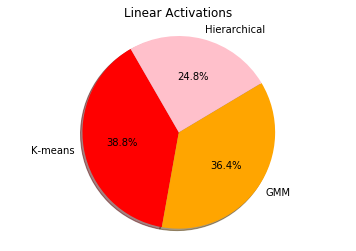

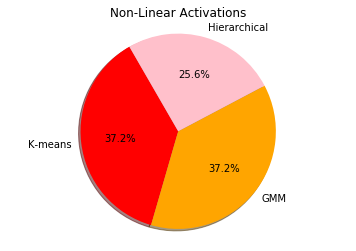

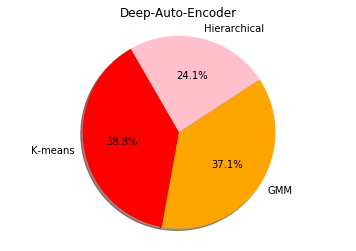

In [150]:
showPIE(KMPurity1,GMMPurity1,HPurity1,"Linear Activations")
showPIE(KMPurity2,GMMPurity2,HPurity2,"Non-Linear Activations")
showPIE(KMPurity3,GMMPurity3,HPurity3,"Deep-Auto-Encoder")